# Deconvolution

The deconvolution attribution method uses a deconvolutional version of the classification model to convert the feature space to pixel space (attribution map). The deconvolutional layers are transposed versions of the convolutional layers, hence why deconvolutions are more accuratly called transposed convolutions. A attribution map can be extracted from any one of the classification models convolutional layers. We will be using the final convolutional layer for the best results. The main downside of this method is the need to create a new model with transposed versions of the convolutional layers. This can become tedious for large models.  

For more technical information on the deconvolution attribution method see: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
from flax.core.frozen_dict import freeze
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-21 10:29:01.549397: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:29:04.242136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:29:04.243029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:29:04.243049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,   
        ])
        x = conv_layers(x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the deconvolutional model
        self.sow("intermediates", "final_conv_layer", x)
        # Flatten for dense layer
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create eh model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ intermedia… ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ _forward_… │ float32[5… │ float32[5… │ final_conv… │            │
│            │            │            │            │ -           │            │
│            │            │            │            │ float32[5,… │            │
│            │            │            │            │             │            │
│            │            │            │            │ 92,160      │            │
│            │            │            │            │ (368.6 KB)  │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ Sequentia… │ Sequential │ float32[5… │ float32[5… │             │            │
├────────────┼────────────┼

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])

    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

Iteration:  0
0.117000006
Iteration:  10
0.74050003
Iteration:  20
0.79150003
Iteration:  30
0.82600003
Iteration:  40
0.83900005
Iteration:  50
0.85850006
Iteration:  60
0.85850006
Iteration:  70
0.86850005
Iteration:  80
0.864
Iteration:  90
0.87200004
Iteration:  100
0.873
Iteration:  110
0.87600005
Iteration:  120
0.87650007
Iteration:  130
0.883
Iteration:  140
0.88100004
Iteration:  150
0.88650006
Iteration:  160
0.8845
Iteration:  170
0.89100003
Iteration:  180
0.8895
Iteration:  190
0.89250004


### Create the Deconvolutional Model

The deconvolutional model is basically the classification models convolutional layers in reverse and transposed. So for a two convolutional layer model, the order becomes:
 - Deconv layer 0 <- Conv layer 1 
 - Deconv layer 1 <- Conv layer 0 
 
Then the feature maps are transposed, so the input and output filter dimensions swap. The kernel is also transposed, but this makes no difference to the dimensions, since they are equal. The (in, out) filter dimensions then become:
 - Deconv layer 0 (32, 16) <- Conv layer 1 (16, 32)
 - Deconv layer 1 (16, 1) <- Conv layer 0 (1, 16)

 

In [8]:
class _deconvolution(nn.Module):

    @nn.compact
    def __call__(self, x):
        deconv = nn.Sequential([
            nn.ConvTranspose(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,   
            nn.ConvTranspose(features=1, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu, 
        ])

        return deconv(x)

# Create the model object
deconvolution = _deconvolution()

# Display the model details
rng_key = random.PRNGKey(64)
dummy_x = X_val[:5]
initial_params = forward_fn.init(rng_key, dummy_x)
_, state = forward_fn.apply(initial_params, dummy_x, mutable='intermediates')
final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
initial_deconv_params = deconvolution.init(rng_key, final_conv_layer)
print(deconvolution.tabulate(rng_key, final_conv_layer))


                             _deconvolution Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ _deconvoluti… │ float32[24,2… │ float32[28,… │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Sequential_0  │ Sequential    │ float32[24,2… │ float32[28,… │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ ConvTranspos… │ ConvTranspose │ float32[24,2… │ float32[26,… │ kernel:       │
│               │               │               │              │ float32[3,3,… │
│               │               │               │              │               │
│               │               │               │              │ 4,608 (18.4   │
│               │          

### Prepare Deconvolutional Parameters

The deconvolutional layers will use transposed versions of the convolutional layers weights. We will need to transpose the kernel dimensions and the filter dimensions to prepare the weights for the deconvolutional layers. The convolutional weight dimensions are given by the tuple (kernel dim 1, kernel dim 2, filter dim in, filter dim out).

In [9]:
print(f"Classification model weights: {list(params['params'].keys())}")
conv_0_kernel_weights = params['params']['Conv_1']['kernel']
conv_1_kernel_weights = params['params']['Conv_0']['kernel']

print(f"Conv layer 1 weight dimensions: {conv_0_kernel_weights.shape}")
print(f"Conv layer 0 weight dimensions: {conv_1_kernel_weights.shape}")

Classification model weights: ['Conv_0', 'Conv_1', 'Dense_0']
Conv layer 1 weight dimensions: (3, 3, 16, 32)
Conv layer 0 weight dimensions: (3, 3, 1, 16)


Now the kernel and filter dims of the convolutioanl layers are transposed for the deconvolutional layer weights.

In [10]:
trans_conv_0_kernel_weights = jnp.transpose(conv_0_kernel_weights, (1, 0, 3, 2))
trans_conv_1_kernel_weights = jnp.transpose(conv_1_kernel_weights, (1, 0, 3, 2))

print(f"Conv layer 0 transposed weight dimensions: {trans_conv_0_kernel_weights.shape}")
print(f"Conv layer 1 transposed weight dimensions: {trans_conv_1_kernel_weights.shape}")

Conv layer 0 transposed weight dimensions: (3, 3, 32, 16)
Conv layer 1 transposed weight dimensions: (3, 3, 16, 1)


The weight dimensions of the transposed convolutional weights are now the same as the deconvolutional layer weights, as shown below.  

In [11]:
print(f"Deconvolutional model weights: {list(initial_deconv_params['params'].keys())}")
print(f"Deconv layer 0 weight dimensions: {initial_deconv_params['params']['ConvTranspose_0']['kernel'].shape}")
print(f"Deconv layer 1 weight dimensions: {initial_deconv_params['params']['ConvTranspose_1']['kernel'].shape}")

Deconvolutional model weights: ['ConvTranspose_0', 'ConvTranspose_1']
Deconv layer 0 weight dimensions: (3, 3, 32, 16)
Deconv layer 1 weight dimensions: (3, 3, 16, 1)


The transposed weights are then added to a params dict and frozen so that it can be used for the deconvolutional model.

In [12]:

deconv_params = {
    "params": {
        "ConvTranspose_0": {"kernel": trans_conv_0_kernel_weights},
        "ConvTranspose_1": {"kernel": trans_conv_1_kernel_weights}
    }
}
# Convert python dict to flax frozen dict
deconv_params = freeze(deconv_params)

### Display predictions and attribution maps

To use the deconvolutional attribution method we need to access the output of a convolutional layer. This method works for any convolutiona layer, but we will only use the last convolutional layer for this demonstration. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. The convolutional layers output is then fed into the deconvolutional model, which outputs the class attribution map. The deconvolutional model uses the transposed weights prepared previously. 


In [13]:
def make_predictions(X, params):
    logits, state = forward_fn.apply(params, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction, state = make_predictions(X_val[None, index], params)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]

    attributions = deconvolution.apply(deconv_params, final_conv_layer)

    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)

    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


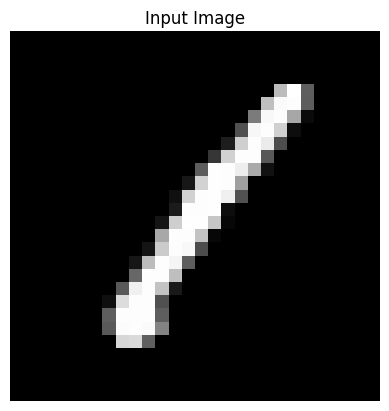

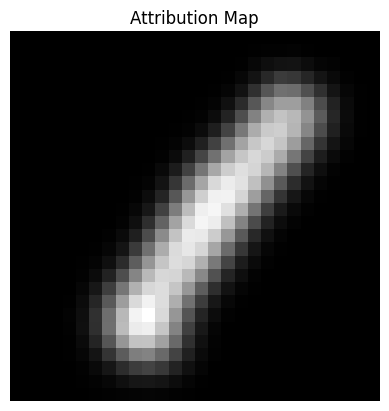

Prediction:  [2]
Label:  4


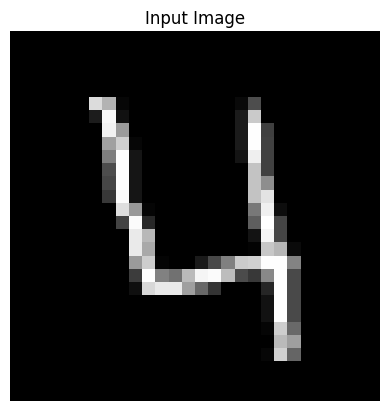

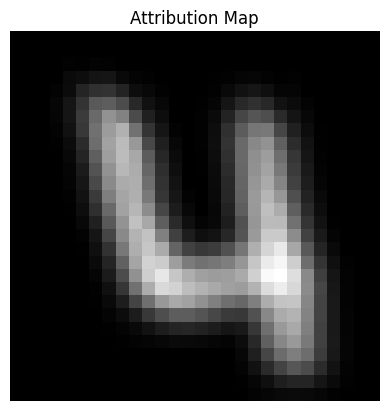

Prediction:  [0]
Label:  0


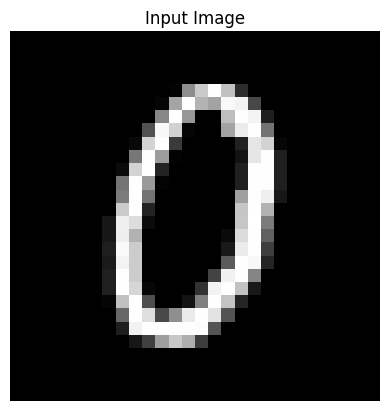

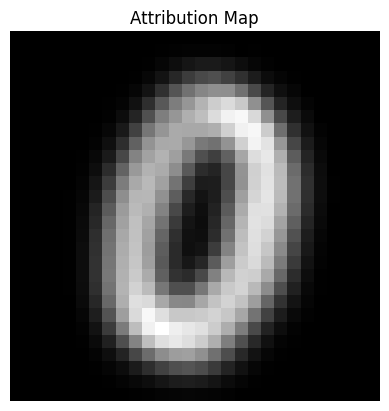

Prediction:  [5]
Label:  5


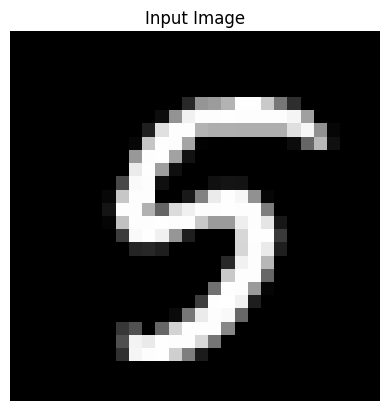

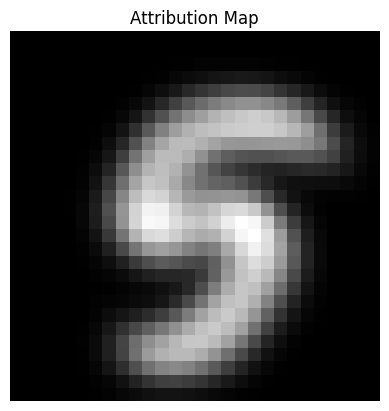

Prediction:  [8]
Label:  8


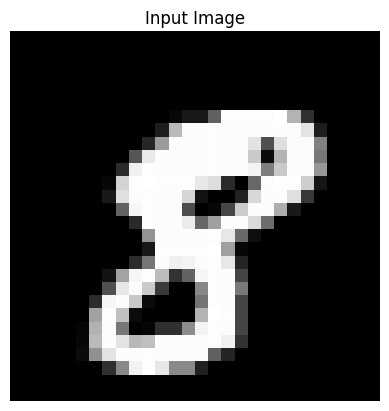

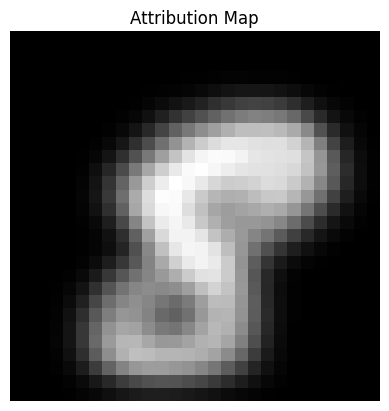

Prediction:  [7]
Label:  7


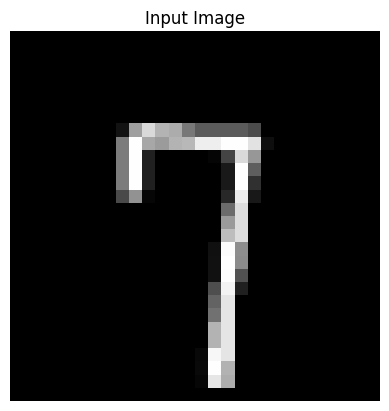

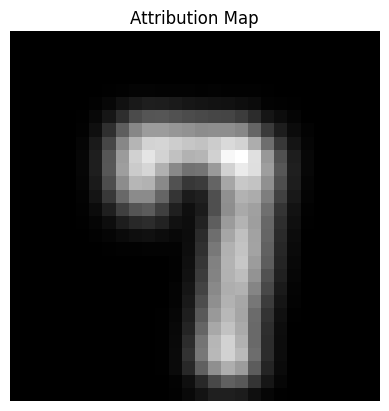

In [14]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)